In [17]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
import serial
import time
from IPython.display import clear_output

%matplotlib inline
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio

import vision
import globalNavigation
import utils
import kalman

# Main


In [19]:
#RUN ONLY ONCE PER KERNEL START TO AVOID BUGS
%matplotlib inline
th = Thymio.serial(port="/dev/cu.usbmodem14401", refreshing_rate=0.1)
cap = vision.VideoCapture("http://192.168.13.124:8080/video")

ini 0.0 , 0.0
Path Original:
[[70, 25], [69, 26], [68, 27], [67, 28], [66, 29], [65, 30], [64, 31], [63, 32], [62, 33], [61, 34], [60, 35], [60, 36], [59, 37], [58, 37], [57, 38], [56, 38], [55, 38], [54, 38], [53, 38], [52, 39], [51, 39], [50, 39], [49, 39], [48, 39], [47, 38], [46, 38], [45, 38], [44, 38], [43, 38], [42, 37], [41, 36], [40, 35], [39, 34], [38, 33], [37, 33], [36, 33], [35, 33], [34, 33], [33, 33], [32, 33], [31, 32], [30, 32], [29, 31], [28, 30], [27, 29], [26, 28], [25, 27], [24, 26], [23, 25], [23, 24], [23, 23], [23, 22], [23, 21], [22, 20], [22, 19], [21, 18], [21, 17], [20, 16], [20, 15], [19, 14], [19, 13]]
Path Simple:
[[1008  360]
 [ 821  547]
 [ 619  547]
 [ 547  475]
 [ 432  461]
 [ 331  360]
 [ 274  187]]
[[1008  360]
 [ 821  547]
 [ 619  547]
 [ 547  475]
 [ 432  461]
 [ 331  360]
 [ 274  187]]
path index: 0
angleToTurn: -35.67834703410789
ini 100 , -100
ini 0 , 0
ini 100 , 100
start the thread
ratio [1.21077987]
moving to left 95 , 105
ratio [1.02596115]

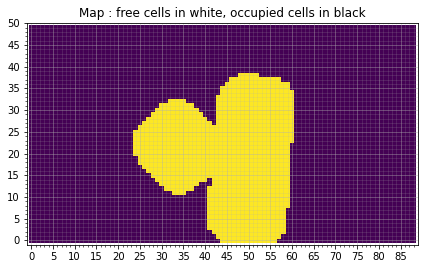

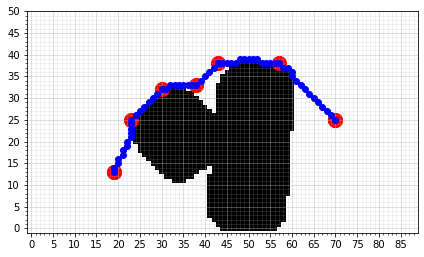

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/ken/anaconda3/envs/opencv4/lib/python3.9/site-packages/serial/serialposix.py", line 621, in write
    n = os.write(self.fd, d)
OSError: [Errno 6] Device not configured

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ken/anaconda3/envs/opencv4/lib/python3.9/threading.py", line 950, in _bootstrap_inner
    self.run()
  File "/Users/ken/anaconda3/envs/opencv4/lib/python3.9/threading.py", line 888, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ken/Dropbox/EPFL/Basics_of_Mobile_Robotics/Project/EPFL_MoRo_Project/src/Thymio.py", line 340, in do_refresh
    self.get_variables()
  File "/Users/ken/Dropbox/EPFL/Basics_of_Mobile_Robotics/Project/EPFL_MoRo_Project/src/Thymio.py", line 499, in get_variables
    self.send(msg)
  File "/Users/ken/Dropbox/EPFL/Basics_of_Mobile_Robotics/Project/EPFL_MoRo_Project/src/Thymio.py", l

In [22]:
import importlib
importlib.reload(vision)
importlib.reload(globalNavigation)
importlib.reload(utils)
importlib.reload(kalman)

reachedEnd = False
destinationCenter = None

while not reachedEnd:
    
    ourThymio = utils.virtualThymio(cap,th)
    path, destinationCenter = utils.analyze(ourThymio, destinationCenter)
    print(path)
    reachedEnd = globalNavigation.followPath(ourThymio, path)
    reachedEnd = True


# Manual Debug

#### Read image and display it

<Figure size 432x288 with 0 Axes>

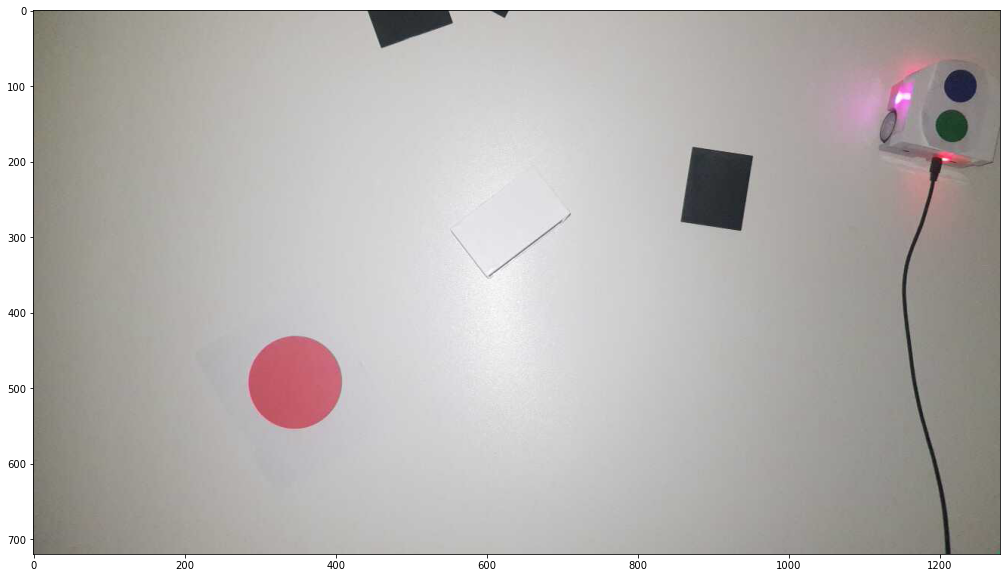

In [5]:
#RUN CELL 1 TO HAVE IMPORTS
%matplotlib inline
capDebug = vision.VideoCapture("http://192.168.13.124:8080/video")

plt.figure()
viewCam = False

while viewCam:
    frameDebug = capDebug.read()
    frameDebug = cv2.cvtColor(frameDebug,cv2.COLOR_BGR2RGB)
    plt.imshow(frameDebug)
    plt.show()
    time.sleep(1)
    clear_output()
    
raw_frame = capDebug.read()
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(raw_frame,cv2.COLOR_BGR2RGB))
plt.show()


In [1]:
th.set_var('motor.left.target', 0)
th.set_var('motor.right.target', 0)

NameError: name 'th' is not defined

In [ ]:
importlib.reload(vision)
%matplotlib inline
frame = raw_frame.copy()
robot_front_absolute, front_image = vision.find_thymio_front(frame)
robot_center_absolute, center_image = vision.find_thymio_center(frame)
destination_center_absolute, destination_image = vision.find_destination_center(frame)
plt.figure(figsize = (50,10))
plt.imshow(front_image)
plt.show()
plt.figure(figsize = (50,10))
plt.imshow(center_image)
plt.show()
plt.figure(figsize = (50,10))
plt.imshow(destination_image)
plt.show()

In [ ]:
importlib.reload(vision)
%matplotlib inline
importlib.reload(vision)
output_objects = vision.find_objects(frame)
output_objects = cv2.cvtColor(output_objects, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (50,10))
plt.imshow(output_objects)
plt.show()

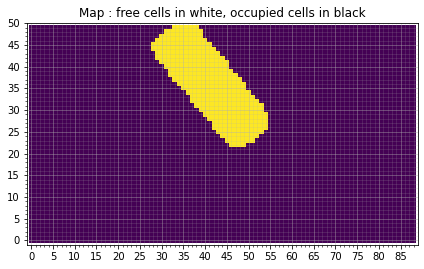

In [20]:
importlib.reload(globalNavigation)
occupancy_grid, cmap = globalNavigation.display_occupancy_grid(output_objects)

array([[70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55,
        54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39,
        38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23,
        22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,
         6,  5],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5]])

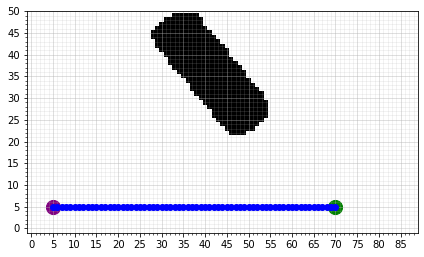

In [22]:
# Define the start and end goal
start = (70,5)
goal = (5,5)

globalNavigation.runAstar(start, goal, utils.A_STAR_Y_AXIS_SIZE, occupancy_grid, cmap)

In [96]:
th.set_var('motor.left.target', 50)
th.set_var('motor.right.target', 50)

In [4]:
th.set_var('motor.left.target', 0)
th.set_var('motor.right.target', 0)

NameError: name 'th' is not defined

In [10]:
import localNavigation
importlib.reload(vision)
importlib.reload(globalNavigation)
importlib.reload(utils)
importlib.reload(localNavigation)

localNavigation.set_motor(0,0,ourThymio)

In [38]:
#with 100 and -100 speed, rotation takes 8.76 sec
#forward value is 37.95

In [27]:
#CODE TO MEASURE THYMIO POSITION AND PLOT IT

importlib.reload(vision)
importlib.reload(globalNavigation)
importlib.reload(utils)

ourThymio = utils.virtualThymio(cap,th)

ourThymio.th.set_var('motor.left.target', 50)
ourThymio.th.set_var('motor.right.target', 50)

#th.set_var('motor.left.target', 2**16-50)
#th.set_var('motor.right.target', 2**16-50)


ps=np.array([ourThymio.readKalman()])
for _ in range(20):
    ps = np.append(ps, [ourThymio.readKalman()], axis = 0)
    time.sleep(1)

th.set_var('motor.left.target', 0)
th.set_var('motor.right.target', 0)

plt.plot(ps[:, 0], ps[:, 1])
plt.xlim(0, 1280)
plt.ylim(0, 720)
print(ps)

ini 0.0 , 0.0


KeyboardInterrupt: 

In [33]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise


tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 0.1 # time step

tracker.F = np.array([[1, 0, dt,  0],
                      [0,  1, 0,  dt],
                      [0,  0, 1,  0],
                      [0,  0, 0,  1]])
q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)
tracker.H = np.diag([1.,1.,1.,1.])
tracker.R = np.diag([5.,5.,3.,3.])

[[2.5e-08 5.0e-07 0.0e+00 0.0e+00]
 [5.0e-07 1.0e-05 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 2.5e-08 5.0e-07]
 [0.0e+00 0.0e+00 5.0e-07 1.0e-05]]


In [2]:
from threading import Timer,Thread,Event

class MyThread(Thread):
    def __init__(self, event):
        Thread.__init__(self)
        self.stopped = event

    def run(self):
        while not self.stopped.wait(0.5):
            a = 1
            print("my thread")
            # call a function

In [ ]:
stopFlag = Event()
thread = MyThread(stopFlag)
thread.start()
time.sleep(5)
# this will stop the timer
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
time.sleep(5)
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
stopFlag.set()
print('salut')
print('salut')
time.sleep(5)
print('rien passé')
stopFlag.clear()
thread = MyThread(stopFlag)
thread.start()
print('salut')
print('salut')
print('salut')
time.sleep(5)
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
print('salut')
stopFlag.set()

# Kalman Testing

In [2]:
#RUN ONLY ONCE PER KERNEL START TO AVOID BUGS
%matplotlib inline
th = Thymio.serial(port="/dev/cu.usbmodem14401", refreshing_rate=0.1)
cap = vision.VideoCapture("http://192.168.13.124:8080/video")

In [10]:
th.set_var('motor.left.target', 0)
th.set_var('motor.right.target', 0)
globalNavigation.turnAngle(np.deg2rad(180), ourThymio)

ini -100 , 100
ini 0 , 0


In [ ]:
import importlib
import kalman
import localNavigation
importlib.reload(vision)
importlib.reload(globalNavigation)
importlib.reload(localNavigation)
importlib.reload(utils)
importlib.reload(kalman)

ourThymio = utils.virtualThymio(cap,th)

#Goes forward towards next goal, kalman and local avoidance is active
ourThymio.stopKalmanFlag.clear()
kThread = kalman.kalmanThread(ourThymio)

globalNavigation.goForward(500, ourThymio)

kThread.start()

while not globalNavigation.REACHED:
    #check if collision
    wentInLocal = localNavigation.localCheck(ourThymio)
    #check if local nav ended
    if wentInLocal:
        ourThymio.inLocal = False
        break
    # kalman is executed automatically every DT in kThread

globalNavigation.REACHED = False

In [4]:
from threading import Timer,Thread,Event

class MyThread(Thread):
    def __init__(self, event, time):
        Thread.__init__(self)
        self.stopped = event
        self.time = time
        
    def run(self):
        while not self.stopped.wait(self.time):
            print("my thread")
            # call a function

In [7]:
stopFlag = Event()
time = 2
thread = MyThread(stopFlag, time)
thread.start()
# this will stop the timer
stopFlag.set()

In [ ]:
from threading import Timer,Thread,Event
import time

def coucou():
    print('salut')
    print('coucou')

t = Timer(1, lambda: coucou())
t.start()

while True:
    print('bb')
    time.sleep(5)

# Kalman

Our Kalman filtering happens when the Thymio robot goes forward on a straight line. As mentionned above, in the global navigation, the Thymio gets a list of points. It first rotates on itself to face the next point, then it moves straight to that point.
There is no Kalman filter for the rotation part. This is because we found that it was sufficient in terms of accuracy because our filter takes into account the orientation of the robot when it is moving.

We used the FilterPy library to implement our Kalman Filter. This library does nothing special expect saving us time with matrix multiplications. Indeed it checks for us that the matrices have the right size and provides simple functions to make the code more readable.

The following model for our model was chosen. Naming convention follows FilterPy which is slightly different from class notation but the structure is the same.
We chose the following state predictor function.
$$\bar x = F\cdot = \begin{bmatrix} 1 & 0 & 0 & dt \\ 0 & 1 & 0 & dt \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix}$$



In [ ]:
import localNavigation
importlib.reload(vision)
importlib.reload(globalNavigation)
importlib.reload(utils)
importlib.reload(localNavigation)

localNavigation.set_motor(0,0,ourThymio)

In [ ]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise


tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 0.1 # time step

tracker.F = np.array([[1, 0, dt,  0],
                      [0,  1, 0,  dt],
                      [0,  0, 1,  0],
                      [0,  0, 0,  1]])
q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)
tracker.H = np.diag([1.,1.,1.,1.])
tracker.R = np.diag([5.,5.,3.,3.])